In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
sns.set(rc={'figure.figsize': (20, 10)})

In [4]:
events_data = pd.read_csv('C:/Users/stasz/data-sets/event_data_train.csv')
submissions_data = pd.read_csv('C:/Users/stasz/data-sets/submissions_data_train.csv')

In [5]:
submissions_data.head(10)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853
7,31977,1434347371,correct,15853
8,31978,1434349981,correct,15853
9,31979,1434446091,correct,15853


In [6]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [7]:
submissions_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [8]:
submissions_data['day'] = submissions_data.date.dt.date

In [9]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

viewed - подивитися степ, passed - вирішити його, discovered - перший раз його побачити, started_attempt - почати вирішувати

In [10]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

створюємо нову колонку 'date' в датафреймі events_data, в якій перетворені значення колонки 'timestamp'

In [11]:
events_data['day'] = events_data.date.dt.date

In [12]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 04:00:48,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 04:00:48,2015-06-15
2,31972,1478852149,wrong,15853,2015-06-15 04:00:48,2015-06-15
3,31972,1478852164,correct,15853,2015-06-15 04:01:35,2015-06-15
4,31976,1434348123,wrong,15853,2015-06-15 04:01:35,2015-06-15


In [13]:
submissions_data[submissions_data['submission_status'] == 'correct'] \
    .groupby('user_id') \
    .agg({'submission_status': 'count'}) \
    .submission_status.sort_values(ascending=False)

user_id
1046     421
5552     186
17135    168
6183     142
8461     135
        ... 
6191       1
6184       1
6166       1
15771      1
20633      1
Name: submission_status, Length: 9794, dtype: int64

In [14]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<Axes: xlabel='day'>

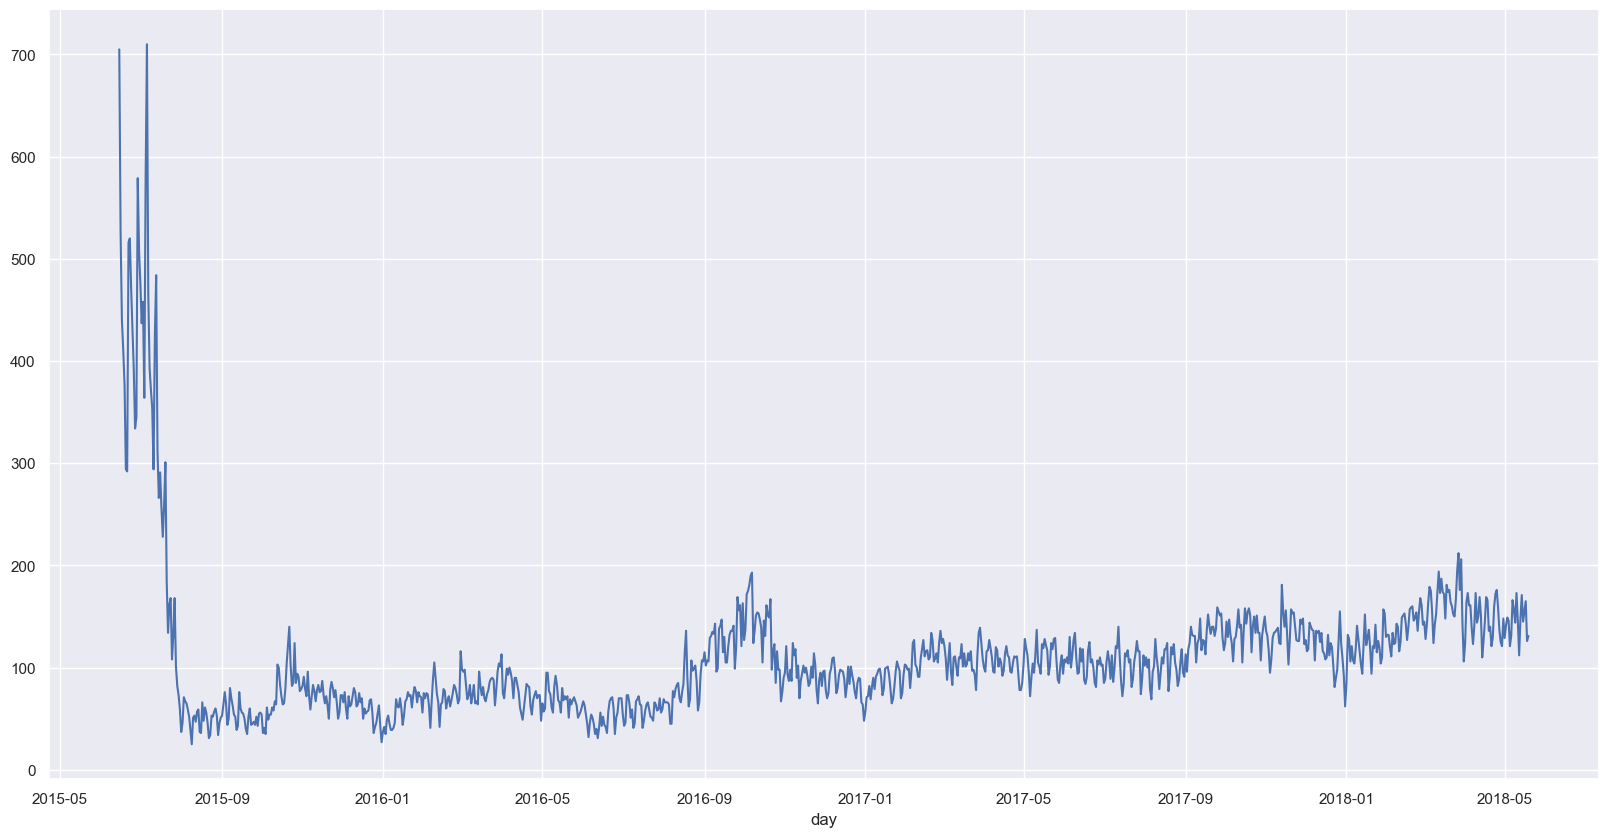

In [15]:
events_data.groupby('day') \
    .user_id.nunique().plot()

розподілення кількості унікальних юзерів, які були активними, для кожного дня

In [16]:
#events_data[events_data.action == 'passed'] \
#    .groupby('user_id', as_index=False) \
#    .agg({'step_id': 'count'}) \
#    .rename(columns={'step_id': 'passed_steps'}) \
#    .passed_steps.hist()

таким способом ми втрачаємо користувачів, у яких немає ні одного 'passed' степу

In [17]:
users_event_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [18]:
users_event_data.passed.sort_values(ascending=False)

4089     198
18822    198
854      198
1256     198
10688    198
        ... 
5535       0
11445      0
16817      0
1747       0
0          0
Name: passed, Length: 19234, dtype: int64

pivot_table розверне нашу таблицю так, що для кожного користувача колонками будуть значення колонки 'action' і в них буде число степів, які пройшли з міткою viewed, passed, discovered, started_attempt

In [19]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [20]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [21]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [22]:
gap_data = gap_data / (24 * 60 * 60)

In [23]:
drop_out_days = gap_data.quantile(0.95) - gap_data.quantile(0.90)

In [24]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [25]:
now = max(events_data.timestamp)
drop_out_thrashold = 24 * 60 * 60 * drop_out_days

In [26]:
users_data['is_gone'] = (now - users_data.last_timestamp) > drop_out_thrashold

In [27]:
users_data.head()

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [28]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [29]:
users_data = users_data.fillna(0)

In [30]:
users_data = users_data.merge(users_event_data, on='user_id', how='outer')

In [31]:
users_days = events_data.groupby('user_id') \
    .day.nunique() \
    .to_frame().reset_index()

In [32]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [33]:
users_data

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [34]:
users_data['passed_course'] = users_data.passed > 170

In [35]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


<Axes: >

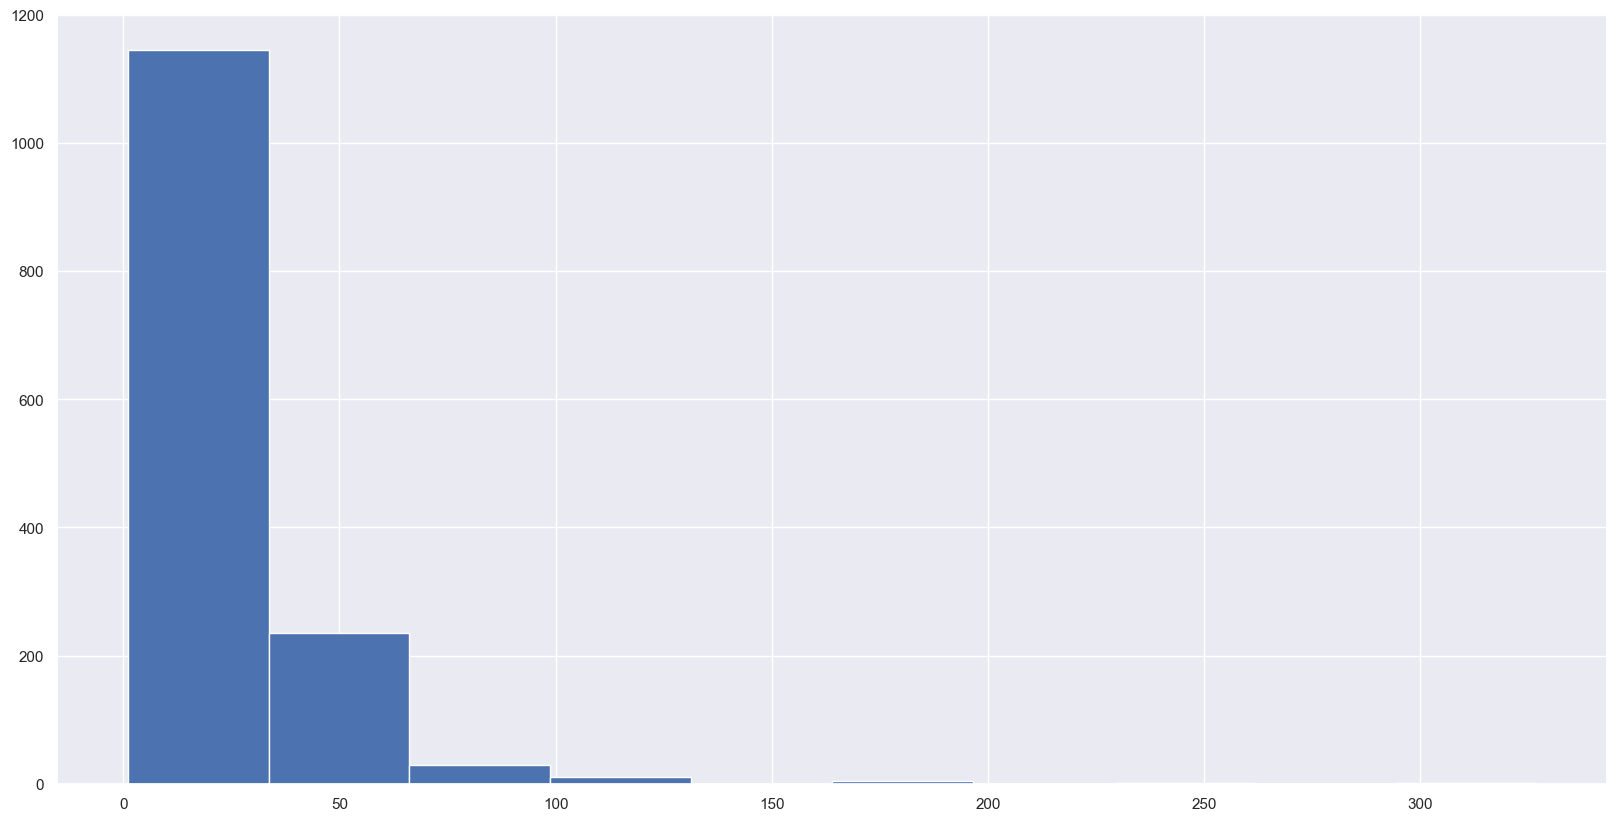

In [36]:
users_data[users_data.passed_course].day.hist()

In [37]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'min'})\
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [38]:
users_data = users_data.merge(user_min_time, how='outer')

In [39]:
users_data.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [40]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [41]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [55]:
event_data_train = pd.DataFrame()

In [56]:
#for user_id in users_data.user_id:
#    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#    time_treshold = min_user_time + 3 * 24 * 60 * 60
#    
#    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
#    
#    event_data_train = event_data_train.append(user_events_data)

In [65]:
event_data_train = events_data[events_data.user_id events_data.timestamp]

In [67]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [68]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [71]:
lerning_time_treshold = 3 * 24 * 60 * 60
lerning_time_treshold

259200

In [77]:
user_lerning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + lerning_time_treshold).map(str)

In [80]:
user_min_time['user_lerning_time_treshold'] = user_lerning_time_treshold

In [82]:
events_data = events_data.merge(user_min_time[['user_id', 'user_lerning_time_treshold']], how='outer')

In [84]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_lerning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [121]:
submissions_data_train = pd.read_csv('C:/Users/stasz/data-sets/submissions_data_train.csv') 

In [148]:
submission_max_time = submissions_data_train[submissions_data_train.submission_status == 'wrong'] \
    .groupby(['step_id', 'user_id'], as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename({'timestamp': 'max_timestamp'})

In [149]:
submission_max_time.head()

,step_id,user_id,timestamp
0,31971,43,1437609479
1,31971,49,1442134666
2,31971,57,1525082345
3,31971,63,1521029891
4,31971,70,1495960630


In [150]:
submission_max_time.step_id.value_counts()

31978    3423
32031    3255
31972    3064
32202    2614
31971    2517
         ... 
33681     300
31986     274
33998     251
32175     199
32929      59
Name: step_id, Length: 76, dtype: int64

In [286]:
submissions_data = submissions_data.merge(user_min_time)

submissions_data_train = submissions_data[submissions_data.timestamp - submissions_data.min_timestamp<=lerning_time_treshold]

In [287]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [306]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_lerning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [307]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns=({'day': 'days'}))

In [308]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns=({'step_id': 'steps_tried'}))

In [309]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [310]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index(), on='user_id', how='outer')

In [311]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [312]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,1,23,23,27,0.46


In [313]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [314]:
X = X.fillna(0)

In [315]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone']], how='outer')

In [316]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,1.0,23.0,23.0,27.0,0.46,132,True,True


In [317]:
X = X[~((X.passed_course == False) & (X.is_gone == False))]

In [318]:
y = X.passed_course.map(int)

In [319]:
X = X.drop(['passed_course', 'is_gone'], axis=1)

In [320]:
X = X.set_index(X.user_id) \
    .drop(['user_id'], axis=1)

In [321]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,1.0,23.0,23.0,27.0,0.46,132


In [341]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [334]:
clf = LogisticRegressionCV(cv=5)

In [336]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=5)

In [337]:
clf.score(X_test,y_test)

0.9181998301726578

In [338]:
clf.coef_

array([[ 0.81507218, -0.02473958,  0.11527246,  0.00609841,  0.57535323,
         0.00087663]])

In [339]:
clf.intercept_

array([-3.93707571])

In [342]:
cross_val_score(clf,X_train,y_train,cv=4).mean()

0.9209485055802931